In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
import pandas as pd

path = r"C:\Users\User\Downloads\Regional_Database_Food+Crime2.xlsx"

dfs = pd.read_excel(path, sheet_name=None)  # dict: {имя_листа: DataFrame}
# пример доступа к одному листу:


In [32]:
path = r"C:\Users\User\Downloads\Regional_Database_Food+Crime2.xlsx"

crime = pd.read_excel(path, sheet_name="Crime_Economics")
food  = pd.read_excel(path, sheet_name="FoodConsumption_TimeSeries")
expandatures = pd.read_excel(path, sheet_name="FoodExpenditure_Rubles").drop(columns=["Federal_District"])
nutrition = pd.read_excel(path, sheet_name="Nutrition_Analysis").drop(columns=["Federal_District"])
share = pd.read_excel(path, "FoodExpenditure_Share").drop(columns=["Federal_District"])


In [33]:
price_level = pd.read_excel(r"C:\Users\User\Downloads\Average_Cost_Rub_per_Unit.xlsx")
cols_to_exclude = ["region", "year", "Federal_District"]

num_cols = price_level.columns.difference(cols_to_exclude)

price_level[num_cols] = price_level[num_cols] * 12



In [34]:
from functools import reduce
dfs = [crime, food, expandatures, nutrition, share]

panel = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=["region", "year"],
        how="inner"   # или "outer", если хочешь не терять строки
    ),
    dfs
)
# если Federal_District тебе больше не нужен:
price_level = price_level.drop(columns=["Federal_District"])

# добавляем в panel по ключам region + year
panel = panel.merge(
    price_level,
    on=["region", "year"],
    how="inner"   # или "left", если хочешь сохранить все строки panel
)

In [35]:
factor_vars = ['grp', 'gini', 'poverty', 'youth', 'colleges',
       'uni', 'higher', 'secondary_prof', 'secondary_general', 'general',
       'uneduc', 'Bread_kg', 'Potatoes_kg',
       'Vegetables_kg', 'Fruits_kg', 'Meat_kg', 'Milk_kg', 'Eggs_units',
       'Fish_kg', 'Sugar_kg', 'Oil_kg', 'Bread_Rub', 'Potatoes_Rub',
       'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub', 'Milk_Rub', 'Eggs_Rub',
       'Fish_Rub', 'Sugar_Rub', 'Oil_Rub', 'Proteins_g', 'Fats_g', 'Carbs_g',
       'Calories_kcal', 'Proteins_animal_g', 'Fats_animal_g', 'Bread_Pct',
       'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct', 'Milk_Pct',
       'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct',
       'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
       'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
       'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
       'Fruits_Cost_Rub_per_kg'
]

crime_vars = [
    "crime_rate", "crime_people", "crime_rate_severe",
    "crime_people_severe", "crime_rate_econ", "crime_people_econ",
    "crime_rate_corruption"
]


In [36]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

df = panel.sort_values(["region", "year"]).copy()

max_lag = 2
alpha = 0.05

rows_factor_to_crime = []

for factor in factor_vars:
    if factor not in df.columns:
        continue
    if not np.issubdtype(df[factor].dtype, np.number):
        continue

    for crime in crime_vars:
        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[factor].shift(lag)   # прошлый фактор [web:35][web:110]
            y = df[crime]                                 # текущая преступность

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])            # [web:109]
            rows_factor_to_crime.append({
                "source": factor,
                "target": crime,
                "direction": "factor→crime",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_factor_to_crime = pd.DataFrame(rows_factor_to_crime)


In [37]:
rows_crime_to_factor = []

for crime in crime_vars:
    for factor in factor_vars:
        if factor not in df.columns:
            continue
        if not np.issubdtype(df[factor].dtype, np.number):
            continue

        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[crime].shift(lag)    # прошлая преступность
            y = df[factor]                                # текущий фактор

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])
            rows_crime_to_factor.append({
                "source": crime,
                "target": factor,
                "direction": "crime→factor",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_crime_to_factor = pd.DataFrame(rows_crime_to_factor)


In [38]:
alpha = 0.05

sig1 = df_factor_to_crime[df_factor_to_crime["p_value"] < alpha].copy()
sig2 = df_crime_to_factor[df_crime_to_factor["p_value"] < alpha].copy()

for d in (sig1, sig2):
    d["abs_r"] = d["r"].abs()

sig1 = sig1.sort_values(["abs_r", "lag"], ascending=[False, True])
sig2 = sig2.sort_values(["abs_r", "lag"], ascending=[False, True])

# добавим столбец с направлением
sig1["direction"] = "factor→crime"
sig2["direction"] = "crime→factor"

# возьмём только нужные столбцы (подставь свои реальные имена переменных)
cols = ["direction", "source", "target", "lag", "r", "p_value", "abs_r"]

top1 = sig1.head(30)[cols]
top2 = sig2.head(30)[cols]

top_all = pd.concat([top1, top2], axis=0).reset_index(drop=True)
df_correl = top_all
df_correl


,direction,source,target,lag,r,p_value,abs_r
0,factor→crime,Milk_Cost_Rub_per_kg,crime_people_severe,2,0.544926,9.224743e-27,0.544926
1,factor→crime,Vegetables_Cost_Rub_per_kg,crime_people_severe,2,0.542258,1.813388e-26,0.542258
2,factor→crime,Vegetables_Cost_Rub_per_kg,crime_people_severe,1,0.516233,2.646825e-29,0.516233
3,factor→crime,Milk_kg,crime_people,2,-0.514025,1.622386e-23,0.514025
4,factor→crime,Milk_Cost_Rub_per_kg,crime_people_severe,1,0.513779,5.364368e-29,0.513779
5,factor→crime,Milk_kg,crime_people,1,-0.508911,2.141726e-28,0.508911
6,factor→crime,general,crime_people,2,0.499300,4.402872e-22,0.499300
7,factor→crime,Vegetables_kg,crime_people,1,-0.497938,4.479494e-27,0.497938
8,factor→crime,general,crime_people,1,0.497122,5.591819e-27,0.497122
9,factor→crime,Vegetables_kg,crime_people,2,-0.490217,3.118716e-21,0.490217


In [39]:
df_correl.to_excel("correlation_food_crime.xlsx")

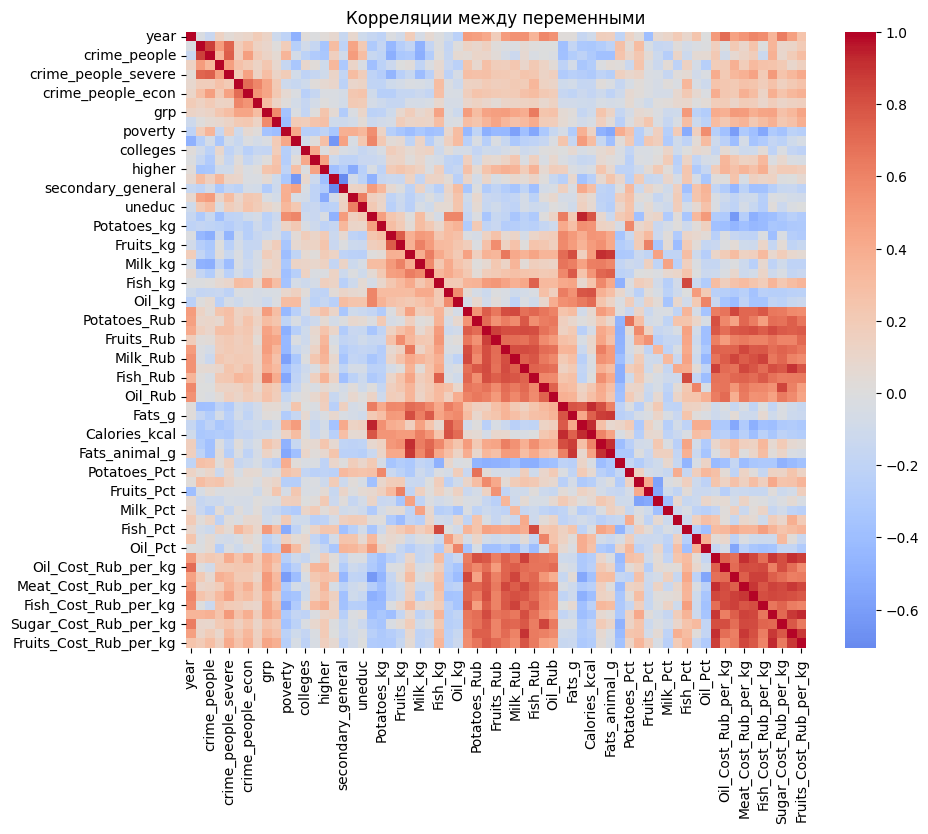

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = panel.select_dtypes(include=[np.number]).corr(method='pearson') 
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Корреляции между переменными')
plt.show()


In [42]:
factor_vars = [
    'grp', 'gini', 'poverty', 'youth', 'colleges', 'uni', 'higher',
    'secondary_prof', 'secondary_general', 'general', 'uneduc',
    'Federal_District_x',
    'Bread_kg', 'Potatoes_kg', 'Vegetables_kg', 'Fruits_kg', 'Meat_kg',
    'Milk_kg', 'Eggs_units', 'Fish_kg', 'Sugar_kg', 'Oil_kg',
    'Bread_Rub', 'Potatoes_Rub', 'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub',
    'Milk_Rub', 'Eggs_Rub', 'Fish_Rub', 'Sugar_Rub', 'Oil_Rub',
    'Proteins_g', 'Fats_g', 'Carbs_g', 'Calories_kcal',
    'Proteins_animal_g', 'Fats_animal_g',
    'Bread_Pct', 'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct',
    'Milk_Pct', 'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct',
    'Federal_District_y',
    'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
    'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
    'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
    'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
    'Fruits_Cost_Rub_per_kg'
]

crime_vars = [
    'crime_rate', 'crime_people', 'crime_rate_severe',
    'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
    'crime_rate_corruption'
]
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

df = panel.sort_values(["region", "year"]).copy()

max_lag = 5
alpha = 0.05

rows_f2c = []

for factor in factor_vars:
    if factor not in df.columns:
        continue
    if not np.issubdtype(df[factor].dtype, np.number):
        continue

    for crime in crime_vars:
        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[factor].shift(lag)   # прошлый фактор [web:35][web:110]
            y = df[crime]                                 # текущая преступность

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])            # [web:25][web:109]
            rows_f2c.append({
                "source": factor,
                "target": crime,
                "direction": "factor→crime",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_f2c = pd.DataFrame(rows_f2c)
rows_c2f = []

for crime in crime_vars:
    for factor in factor_vars:
        if factor not in df.columns:
            continue
        if not np.issubdtype(df[factor].dtype, np.number):
            continue

        for lag in range(1, max_lag + 1):
            x = df.groupby("region")[crime].shift(lag)   # прошлая преступность
            y = df[factor]                               # текущий фактор

            mask = x.notna() & y.notna()
            if mask.sum() < 5:
                continue

            r, p = pearsonr(x[mask], y[mask])
            rows_c2f.append({
                "source": crime,
                "target": factor,
                "direction": "crime→factor",
                "lag": lag,
                "r": r,
                "p_value": p
            })

df_c2f = pd.DataFrame(rows_c2f)
alpha = 0.05

for d in (df_f2c, df_c2f):
    d["abs_r"] = d["r"].abs()

sig_f2c = df_f2c[df_f2c["p_value"] < alpha].sort_values(
    ["abs_r", "lag"], ascending=[False, True]
)
sig_c2f = df_c2f[df_c2f["p_value"] < alpha].sort_values(
    ["abs_r", "lag"], ascending=[False, True]
)
cols = ["direction", "source", "target", "lag", "r", "p_value", "abs_r"]
top1 = sig_f2c[cols]
top2 = sig_c2f[cols]

top_all = pd.concat([top1, top2], axis=0).reset_index(drop=True)
df_correl = top_all
df_correl





,direction,source,target,lag,r,p_value,abs_r
0,factor→crime,general,crime_people,4,0.591051,7.974825e-17,0.591051
1,factor→crime,general,crime_people,5,0.586978,6.801939e-09,0.586978
2,factor→crime,general,crime_rate,4,0.554695,1.291887e-14,0.554695
3,factor→crime,Milk_Cost_Rub_per_kg,crime_people_severe,3,0.552309,4.790370e-21,0.552309
4,factor→crime,general,crime_people,3,0.546593,1.450663e-20,0.546593
...,...,...,...,...,...,...,...
2137,crime→factor,crime_rate_severe,Sugar_Pct,1,-0.099197,4.470627e-02,0.099197
2138,crime→factor,crime_rate_econ,Proteins_g,1,-0.098914,4.532293e-02,0.098914
2139,crime→factor,crime_rate_corruption,Fats_g,1,-0.097588,4.830339e-02,0.097588
2140,crime→factor,crime_people_econ,Carbs_g,1,-0.097357,4.883826e-02,0.097357


In [43]:
# предполагаем, что sig_f2c и sig_c2f уже отфильтрованы по p_value < alpha
# и содержат колонки: source, target, direction, lag, r, p_value

# ключ для пары без направления
sig_f2c["pair"] = sig_f2c["source"] + "||" + sig_f2c["target"]
sig_c2f["pair"] = sig_c2f["target"] + "||" + sig_c2f["source"]
# во втором случае меняем местами, чтобы (factor, crime) совпадали по строке

# пары, где есть и factor→crime, и crime→factor
both_pairs = set(sig_f2c["pair"]) & set(sig_c2f["pair"])

# оставляем только «односторонние» связи
sig_f2c_clean = sig_f2c[~sig_f2c["pair"].isin(both_pairs)].drop(columns=["pair"])
sig_c2f_clean = sig_c2f[~sig_c2f["pair"].isin(both_pairs)].drop(columns=["pair"])

top1 = sig_f2c_clean[cols]
top2 = sig_c2f_clean[cols]

top_all = pd.concat([top1, top2], axis=0).reset_index(drop=True)
df_correl_clean = top_all
df_correl_clean


,direction,source,target,lag,r,p_value,abs_r
0,factor→crime,uneduc,crime_rate_econ,4,0.365724,0.000001,0.365724
1,factor→crime,Sugar_Cost_Rub_per_kg,crime_people,4,0.326358,0.000020,0.326358
2,factor→crime,Sugar_Cost_Rub_per_kg,crime_people,5,0.317899,0.003610,0.317899
3,factor→crime,Sugar_Cost_Rub_per_kg,crime_rate,5,0.298236,0.006500,0.298236
4,factor→crime,Meat_Pct,crime_people,5,-0.295850,0.006963,0.295850
...,...,...,...,...,...,...,...
150,crime→factor,crime_people,Oil_Cost_Rub_per_kg,1,-0.100302,0.042368,0.100302
151,crime→factor,crime_rate_corruption,Carbs_g,1,-0.099711,0.043606,0.099711
152,crime→factor,crime_rate_corruption,Meat_Rub,1,0.099591,0.043861,0.099591
153,crime→factor,crime_rate_severe,Sugar_Pct,1,-0.099197,0.044706,0.099197


In [44]:
arr = df_correl

In [45]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

food_cols = [
    'Bread_kg', 'Potatoes_kg', 'Vegetables_kg', 'Fruits_kg', 'Meat_kg',
    'Milk_kg', 'Eggs_units', 'Fish_kg', 'Sugar_kg', 'Oil_kg',
    'Bread_Rub', 'Potatoes_Rub', 'Vegetables_Rub', 'Fruits_Rub', 'Meat_Rub',
    'Milk_Rub', 'Eggs_Rub', 'Fish_Rub', 'Sugar_Rub', 'Oil_Rub',
    'Proteins_g', 'Fats_g', 'Carbs_g', 'Calories_kcal',
    'Proteins_animal_g', 'Fats_animal_g',
    'Bread_Pct', 'Potatoes_Pct', 'Vegetables_Pct', 'Fruits_Pct', 'Meat_Pct',
    'Milk_Pct', 'Eggs_Pct', 'Fish_Pct', 'Sugar_Pct', 'Oil_Pct',
    'Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
    'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
    'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
    'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
    'Fruits_Cost_Rub_per_kg'
]

crime_cols = [
    'crime_rate', 'crime_people', 'crime_rate_severe',
    'crime_people_severe', 'crime_rate_econ', 'crime_people_econ',
    'crime_rate_corruption'
]

alpha = 0.05
rows = []

for f in food_cols:
    for c in crime_cols:
        x = panel[f]
        y = panel[c]
        mask = x.notna() & y.notna()
        if mask.sum() < 3:
            continue
        r, p = pearsonr(x[mask], y[mask])
        if p < alpha:          # оставить только значимые
            rows.append({"food_var": f, "crime_var": c, "r": r, "p_value": p})

res_sig = pd.DataFrame(rows)
res_sig["abs_r"] = res_sig["r"].abs()
res_sig = res_sig.sort_values("abs_r", ascending=False)
corr_pearson = pd.concat([res_sig])

In [46]:
import statsmodels.formula.api as smf
import pandas as pd

food_vars = [
    'Bread_kg', 'Potatoes_kg', 'Vegetables_kg', 'Fruits_kg',
    'Meat_kg', 'Milk_kg', 'Eggs_units', 'Fish_kg', 'Sugar_kg', 'Oil_kg'
]

price_vars = ['Potatoes_Cost_Rub_per_kg', 'Oil_Cost_Rub_per_kg',
       'Bread_Cost_Rub_per_kg', 'Meat_Cost_Rub_per_kg', 'Milk_Cost_Rub_per_kg',
       'Fish_Cost_Rub_per_kg', 'Vegetables_Cost_Rub_per_kg',
       'Sugar_Cost_Rub_per_kg', 'Eggs_Cost_Rub_per_units',
       'Fruits_Cost_Rub_per_kg'
]
results = []

for v in food_vars:
    # 1. простая модель
    m1 = smf.ols(f"crime_rate ~ {v}", data=panel).fit()

    # 2. с контролем (доход, бедность, возраст, образование + цена/расходы на молоко как в примере)
    m2 = smf.ols(
        f"crime_rate ~ {v} + grp + poverty + youth + higher ",
        data=panel
    ).fit()

    results.append({
        "var": v,
        "beta_simple": m1.params[v],
        "p_simple": m1.pvalues[v],
        "beta_ctrl": m2.params[v],
        "p_ctrl": m2.pvalues[v]
    })

res_df = pd.DataFrame(results)
print(res_df)





             var  beta_simple      p_simple  beta_ctrl        p_ctrl
0       Bread_kg    -0.739585  5.484234e-12  -1.189479  4.760113e-22
1    Potatoes_kg    -0.613221  7.943274e-05  -0.587420  4.907769e-05
2  Vegetables_kg    -1.034140  2.679541e-25  -0.712562  7.131030e-14
3      Fruits_kg    -0.794564  3.768128e-09  -0.278766  3.134668e-02
4        Meat_kg    -0.625902  4.280937e-05  -0.419766  3.850580e-03
5        Milk_kg    -0.547089  2.604247e-29  -0.424855  4.956035e-19
6     Eggs_units    -0.286777  8.775339e-05  -0.304854  7.636620e-06
7        Fish_kg    -0.063000  8.568268e-01   0.182687  5.968781e-01
8       Sugar_kg    -1.459610  8.175790e-05  -1.778617  7.503432e-08
9         Oil_kg     0.035661  9.739718e-01  -0.361583  7.259592e-01


In [47]:
panel["Magnium_g"] = (
    panel["Bread_kg"]     * 0.70 +
    panel["Potatoes_kg"]  * 0.23 +
    panel["Vegetables_kg"]* 0.40 +
    panel["Fruits_kg"]    * 0.15 +
    panel["Meat_kg"]      * 0.22 +
    panel["Milk_kg"]      * 0.12 +  
    panel["Fish_kg"]      * 0.28 +
    panel["Sugar_kg"]     * 0.00 +
    panel["Oil_kg"]       * 0.00
)



In [48]:
controls = ["grp", "gini", "poverty", 'youth', 'colleges',
       'uni', 'higher']

sub = panel[["Magnium_g", "crime_rate"] + controls].dropna()

sub[["Magnium_g", "crime_rate"] + controls].describe()


,Magnium_g,crime_rate,grp,gini,poverty,youth,colleges,uni,higher
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,186.800313,145.081610,0.786615,0.370874,13.302236,0.160238,178.910569,9.213415,31.567970
std,23.209163,44.423196,1.224357,0.024043,4.829835,0.021966,135.636810,18.123507,5.280238
min,122.173877,15.951375,0.127624,0.315000,4.000000,0.114678,7.000000,0.000000,22.000537
25%,173.174057,116.612406,0.349119,0.352000,10.100000,0.146106,86.000000,3.000000,27.896722
50%,183.533178,138.347805,0.477333,0.368000,13.000000,0.157590,145.000000,5.000000,30.663303
75%,198.032992,174.110196,0.682522,0.387250,15.200000,0.170050,242.000000,9.000000,34.147484
max,329.686552,366.284728,11.786365,0.452000,35.800000,0.255310,1158.000000,161.000000,54.582089


In [49]:
from scipy.stats import pearsonr

r_simple, p_simple = pearsonr(sub["Magnium_g"], sub["crime_rate"])
print(f"Без контролей: r = {r_simple:.3f}, p = {p_simple:.4f}, n = {len(sub)}")


Без контролей: r = -0.480, p = 0.0000, n = 492


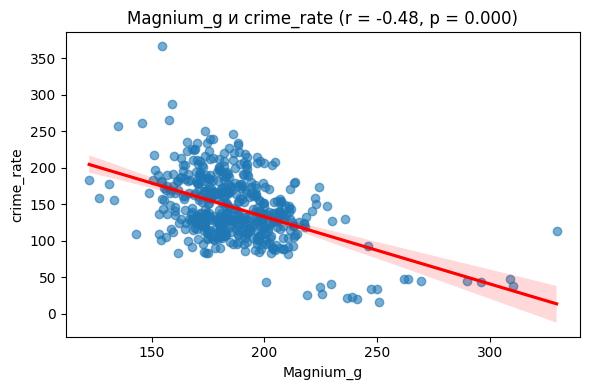

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.regplot(
    data=sub,
    x="Magnium_g",
    y="crime_rate",
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.6}
)
plt.title(f"Magnium_g и crime_rate (r = {r_simple:.2f}, p = {p_simple:.3f})")
plt.xlabel("Magnium_g")
plt.ylabel("crime_rate")
plt.tight_layout()
plt.show()


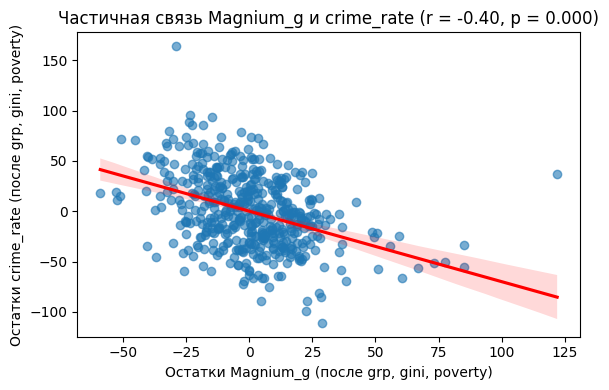

In [53]:
plt.figure(figsize=(6, 4))
sns.regplot(
    x=res_mag,
    y=res_crime,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.6}
)
plt.xlabel("Остатки Magnium_g (после grp, gini, poverty)")
plt.ylabel("Остатки crime_rate (после grp, gini, poverty)")
plt.title(f"Частичная связь Magnium_g и crime_rate (r = {r_part:.2f}, p = {p_part:.3f})")
plt.tight_layout()
plt.show()


In [54]:
# Модель без контролей
model0 = sm.OLS(sub["crime_rate"], sm.add_constant(sub["Magnium_g"])).fit()

# Модель с контролями
X_full = sm.add_constant(sub[["Magnium_g"] + controls])
model1 = sm.OLS(sub["crime_rate"], X_full).fit()

print(model0.summary())
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:             crime_rate   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     146.7
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           1.00e-29
Time:                        20:36:28   Log-Likelihood:                -2499.7
No. Observations:                 492   AIC:                             5003.
Df Residuals:                     490   BIC:                             5012.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        316.7203     14.278     22.182      0.0

In [55]:
from scipy.stats import pearsonr

def corr_by_year(df):
    sub = df[["Magnium_g", "crime_rate"]].dropna()
    if len(sub) < 3 or sub["Magnium_g"].nunique() < 2 or sub["crime_rate"].nunique() < 2:
        return pd.Series({"r": np.nan, "p": np.nan, "n": len(sub)})
    r, p = pearsonr(sub["Magnium_g"], sub["crime_rate"])
    return pd.Series({"r": r, "p": p, "n": len(sub)})

corr_year = panel.groupby("year").apply(corr_by_year).reset_index()
print(corr_year)


   year         r             p     n
0  2017 -0.432304  4.996460e-05  82.0
1  2018 -0.453166  1.910096e-05  82.0
2  2019 -0.482441  4.436844e-06  82.0
3  2020 -0.544660  1.224253e-07  82.0
4  2021 -0.520188  5.474352e-07  82.0
5  2022 -0.532937  2.546102e-07  82.0


C:\Users\User\AppData\Local\Temp\ipykernel_23820\1184652734.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_year = panel.groupby("year").apply(corr_by_year).reset_index()


In [57]:
import pandas as pd

sub_gini = panel[["region", "Magnium_g", "crime_rate", "gini"]].dropna()

sub_gini["gini_tertile"] = pd.qcut(
    sub_gini["gini"],
    3,
    labels=["low_gini", "mid_gini", "high_gini"]
)
from scipy.stats import pearsonr
import numpy as np

def corr_mag_crime(df):
    s = df[["Magnium_g", "crime_rate"]].dropna()
    if len(s) < 3 or s["Magnium_g"].nunique() < 2 or s["crime_rate"].nunique() < 2:
        return pd.Series({"r": np.nan, "p": np.nan, "n": len(s)})
    r, p = pearsonr(s["Magnium_g"], s["crime_rate"])
    return pd.Series({"r": r, "p": p, "n": len(s)})

corr_gini = sub_gini.groupby("gini_tertile").apply(corr_mag_crime).reset_index()
corr_gini["significant"] = corr_gini["p"] < 0.05
print(corr_gini)


  gini_tertile         r             p      n  significant
0     low_gini -0.384903  2.377790e-07  169.0         True
1     mid_gini -0.516185  2.825002e-12  160.0         True
2    high_gini -0.561185  6.605020e-15  163.0         True


C:\Users\User\AppData\Local\Temp\ipykernel_23820\3005638000.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_gini = sub_gini.groupby("gini_tertile").apply(corr_mag_crime).reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_23820\3005638000.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_gini = sub_gini.groupby("gini_tertile").apply(corr_mag_crime).reset_index()


                            OLS Regression Results                            
Dep. Variable:             crime_rate   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     26.40
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           7.86e-20
Time:                        20:36:29   Log-Likelihood:                -2477.2
No. Observations:                 492   AIC:                             4964.
Df Residuals:                     487   BIC:                             4985.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        252.2350     38.221      6.599      0.0

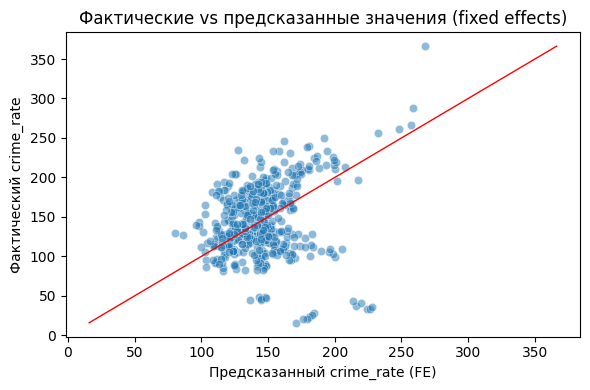

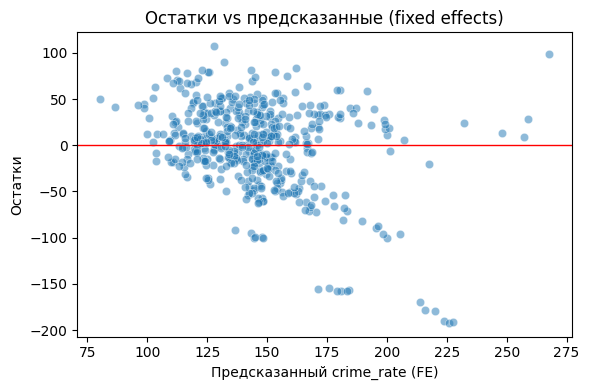

Частичная корреляция (FE + контролы): r = -0.413, p = 1.14e-21


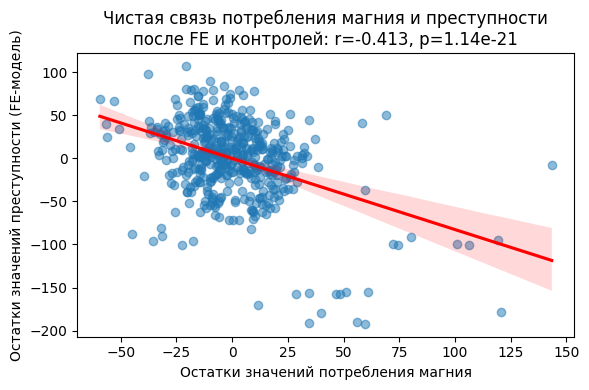

In [58]:
import pandas as pd

# оставляем нужные переменные и убираем пропуски
cols = ["region", "year", "crime_rate", "Magnium_g", "grp", "gini", "poverty"]
df = panel[cols].dropna().copy()
import statsmodels.api as sm

X = df[["Magnium_g", "grp", "gini", "poverty"]]
X = sm.add_constant(X)
y = df["crime_rate"]

ols_model = sm.OLS(y, X).fit(cov_type="HC3")  # робастные SE к гетероскедастичности
print(ols_model.summary())
from linearmodels.panel import PanelOLS

# задаём панельный индекс: регион–год
df_panel = df.set_index(["region", "year"])

y_panel = df_panel["crime_rate"]
X_panel = df_panel[["Magnium_g", "grp", "gini", "poverty"]]

fe_model = PanelOLS(
    y_panel,
    sm.add_constant(X_panel),
    entity_effects=True,  # фиксированные эффекты по регионам
    time_effects=True     # фиксированные эффекты по годам
)
fe_res = fe_model.fit(cov_type="unadjusted")
fe_res_cl_ent = fe_model.fit(
    cov_type="clustered",
    cluster_entity=True,   # кластер по регионам
    cluster_time=False
)
print(fe_res_cl_ent.summary)
fe_res_cl_time = fe_model.fit(
    cov_type="clustered",
    cluster_entity=False,
    cluster_time=True
)
print(fe_res_cl_time.summary)
fe_res_cl_both = fe_model.fit(
    cov_type="clustered",
    cluster_entity=True,
    cluster_time=True
)
print(fe_res_cl_both.summary)
import matplotlib.pyplot as plt
import seaborn as sns

# предсказания FE‑модели
df_panel["crime_pred_fe"] = fe_res.predict()

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=df_panel["crime_pred_fe"],
    y=df_panel["crime_rate"],
    alpha=0.5
)
plt.plot(
    [df_panel["crime_rate"].min(), df_panel["crime_rate"].max()],
    [df_panel["crime_rate"].min(), df_panel["crime_rate"].max()],
    color="red",
    linewidth=1
)
plt.xlabel("Предсказанный crime_rate (FE)")
plt.ylabel("Фактический crime_rate")
plt.title("Фактические vs предсказанные значения (fixed effects)")
plt.tight_layout()
plt.show()
resid_fe = df_panel["crime_rate"] - df_panel["crime_pred_fe"]

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=df_panel["crime_pred_fe"],
    y=resid_fe,
    alpha=0.5
)
plt.axhline(0, color="red", linewidth=1)
plt.xlabel("Предсказанный crime_rate (FE)")
plt.ylabel("Остатки")
plt.title("Остатки vs предсказанные (fixed effects)")
plt.tight_layout()
plt.show()
import statsmodels.api as sm

# регрессия crime_rate только на FE (region+year)
# здесь проще взять остатки из полной FE‑модели по Magnium и контролям
res_crime = resid_fe

# остатки Magnium_g после региональных и годовых FE и контролей
X_ctrl = df_panel[["grp", "gini", "poverty"]]
X_ctrl = sm.add_constant(X_ctrl)
model_mag = sm.OLS(df_panel["Magnium_g"], X_ctrl).fit()
res_mag = model_mag.resid
from scipy.stats import pearsonr

r_fe, p_fe = pearsonr(res_mag, res_crime)
print(f"Частичная корреляция (FE + контролы): r = {r_fe:.3f}, p = {p_fe:.3g}")

plt.figure(figsize=(6, 4))
sns.regplot(
    x=res_mag,
    y=res_crime,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
plt.xlabel("Остатки значений потребления магния")
plt.ylabel("Остатки значений преступности (FE-модель)")
plt.title(
    "Чистая связь потребления магния и преступности\n"
    f"после FE и контролей: r={r_fe:.3f}, p={p_fe:.3g}"
)
plt.tight_layout()
plt.show()



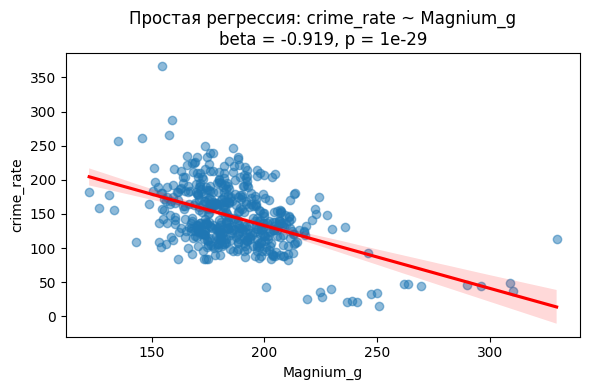

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

sub = panel[["Magnium_g", "crime_rate"]].dropna()
X_simple = sm.add_constant(sub["Magnium_g"])
y_simple = sub["crime_rate"]
ols_simple = sm.OLS(y_simple, X_simple).fit()

beta_simple = ols_simple.params["Magnium_g"]
p_simple = ols_simple.pvalues["Magnium_g"]

plt.figure(figsize=(6, 4))
sns.regplot(
    data=sub,
    x="Magnium_g",
    y="crime_rate",
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.5}
)
plt.title(f"Простая регрессия: crime_rate ~ Magnium_g\n"
          f"beta = {beta_simple:.3f}, p = {p_simple:.3g}")
plt.tight_layout()
plt.show()


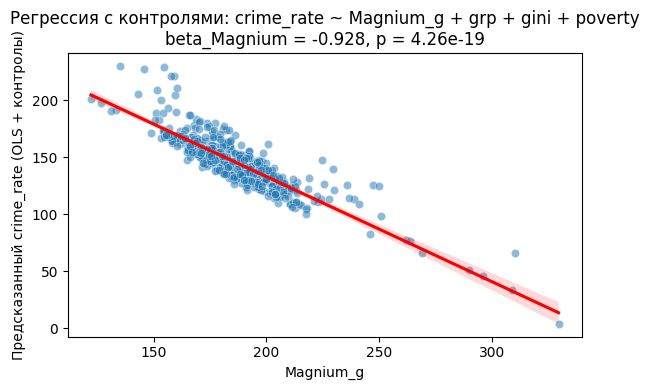

In [60]:
cols = ["Magnium_g", "crime_rate", "grp", "gini", "poverty"]
sub_ctrl = panel[cols].dropna()

X_ctrl = sm.add_constant(sub_ctrl[["Magnium_g", "grp", "gini", "poverty"]])
y_ctrl = sub_ctrl["crime_rate"]
ols_ctrl = sm.OLS(y_ctrl, X_ctrl).fit(cov_type="HC3")

sub_ctrl["crime_pred_ols"] = ols_ctrl.predict(X_ctrl)

beta_ctrl = ols_ctrl.params["Magnium_g"]
p_ctrl = ols_ctrl.pvalues["Magnium_g"]

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=sub_ctrl,
    x="Magnium_g",
    y="crime_pred_ols",
    alpha=0.5
)
sns.regplot(
    data=sub_ctrl,
    x="Magnium_g",
    y="crime_pred_ols",
    scatter=False,
    color="red"
)
plt.xlabel("Magnium_g")
plt.ylabel("Предсказанный crime_rate (OLS + контролы)")
plt.title(f"Регрессия с контролями: crime_rate ~ Magnium_g + grp + gini + poverty\n"
          f"beta_Magnium = {beta_ctrl:.3f}, p = {p_ctrl:.3g}")
plt.tight_layout()
plt.show()


In [61]:
from scipy.stats import pearsonr

# простой r (без контролей)
r_simple, rp_simple = pearsonr(sub["Magnium_g"], sub["crime_rate"])

# r между Magnium_g и предсказанным crime_rate по модели с контролями
sub["crime_pred_ctrl"] = ols_ctrl.predict(X_ctrl)
r_ctrl, rp_ctrl = pearsonr(sub["Magnium_g"], sub["crime_pred_ctrl"])


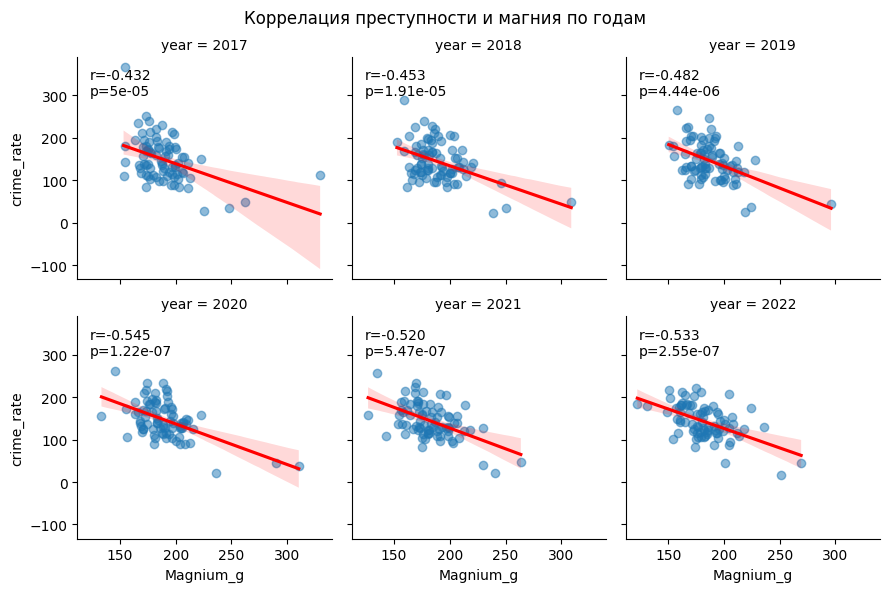

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

sub_year = panel[["year", "Magnium_g", "crime_rate"]].dropna()

def annotate_corr(data, **kws):
    r, p = pearsonr(data["Magnium_g"], data["crime_rate"])  # [web:379][web:381]
    ax = plt.gca()
    ax.text(
        0.05, 0.95,
        f"r={r:.3f}\np={p:.3g}",
        transform=ax.transAxes,
        va="top"
    )  # [web:368][web:349]

g = sns.lmplot(
    data=sub_year,
    x="Magnium_g",
    y="crime_rate",
    col="year",
    col_wrap=3,
    height=3,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)

g.map_dataframe(annotate_corr)
g.set_axis_labels("Magnium_g", "crime_rate")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Коррелация преступности и магния по годам")



plt.show()


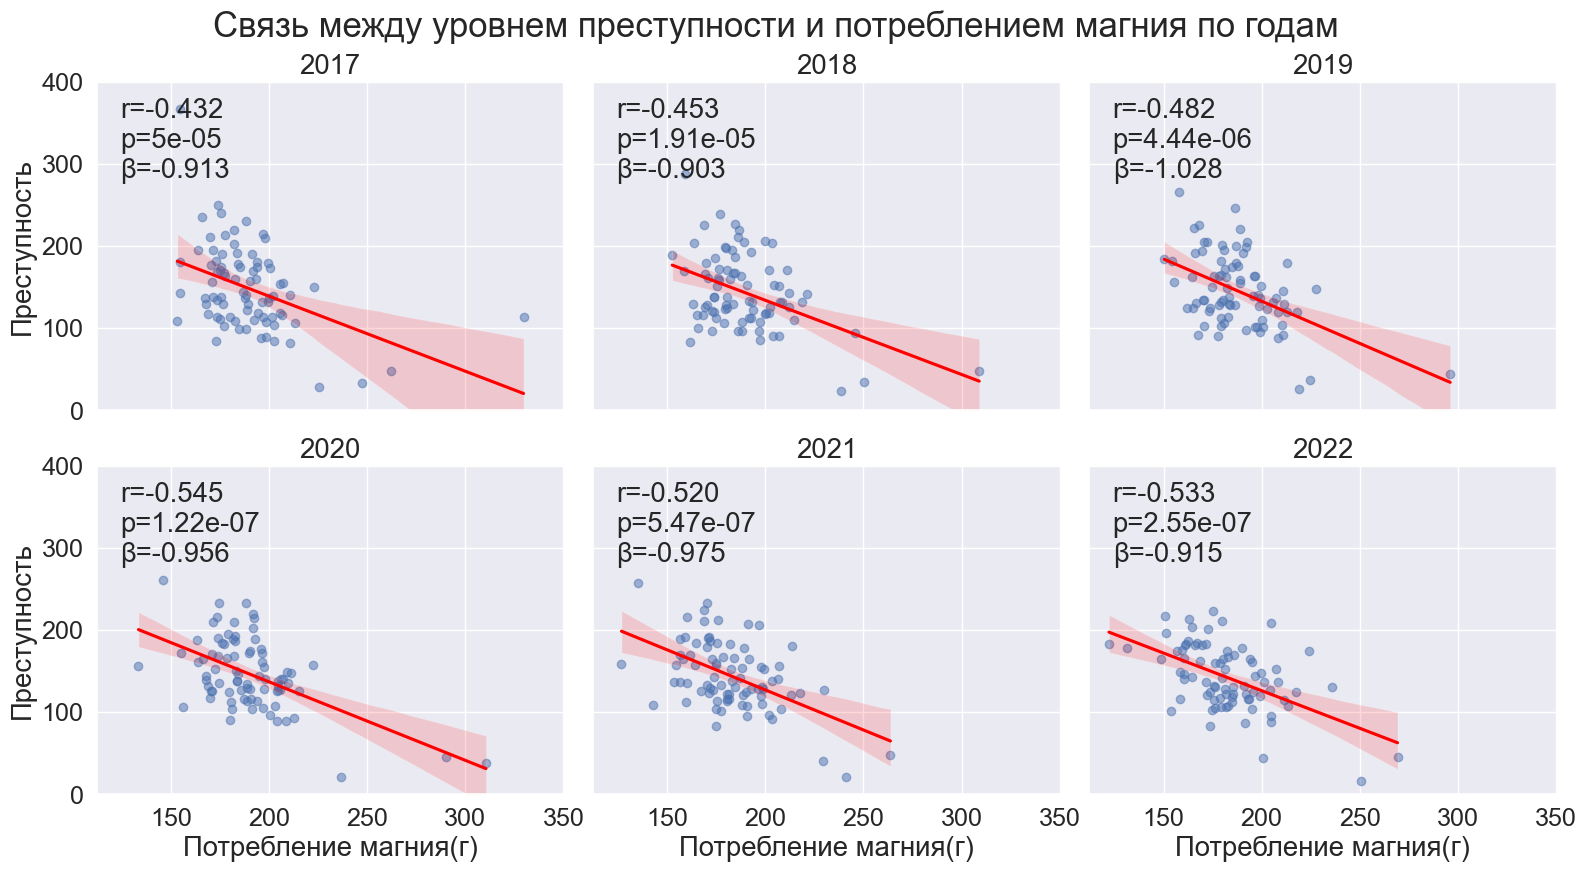

In [63]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def annotate_corr_beta(data, **kws):
    x = data["Magnium_g"]
    y = data["crime_rate"]

    # r и p
    r, p = pearsonr(x, y)

    # OLS по году, beta по Magnium_g
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    beta = model.params["Magnium_g"]

    ax = plt.gca()
    ax.text(
        0.05, 0.95,
        f"r={r:.3f}\np={p:.3g}\nβ={beta:.3f}",
        transform=ax.transAxes,
        ha="left", va="top"
    )

sns.set(font_scale=1.65)
g = sns.lmplot(
    data=sub_year,
    x="Magnium_g",
    y="crime_rate",
    col="year",
    col_wrap=3,
    height=4.5,
    aspect=1.2,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)

# вместо старого annotate_corr:
g.map_dataframe(annotate_corr_beta)

g.set_axis_labels("Потребление магния(г)", "Преступность")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Связь между уровнем преступности и потреблением магния по годам", fontsize=25)

plt.xlim(sub["Magnium_g"].min() - 10, 350)
plt.ylim(0, 400)

plt.show()


In [64]:
from scipy.stats import pearsonr  # [web:381][web:404]

sub = panel[["Magnium_g", "crime_rate"]].dropna()

r_simple, p_simple = pearsonr(sub["Magnium_g"], sub["crime_rate"])
print(f"Простая корреляция: r = {r_simple:.3f}, p = {p_simple:.3g}")


Простая корреляция: r = -0.480, p = 1e-29


In [65]:
import statsmodels.api as sm

cols = ["Magnium_g", "crime_rate", "grp", "gini", "poverty"]
sub_ctrl = panel[cols].dropna().copy()

X_ctrl = sm.add_constant(sub_ctrl[["grp", "gini", "poverty"]])

# вынимаем влияние контролей из Magnium_g
model_mg = sm.OLS(sub_ctrl["Magnium_g"], X_ctrl).fit()
res_mg = model_mg.resid

# вынимаем влияние контролей из crime_rate
model_cr = sm.OLS(sub_ctrl["crime_rate"], X_ctrl).fit()
res_cr = model_cr.resid

# корреляция между «очищенными» переменными
r_partial, p_partial = pearsonr(res_mg, res_cr)
print(f"Частичная корреляция (контроли grp, gini, poverty): r = {r_partial:.3f}, p = {p_partial:.3g}")


Частичная корреляция (контроли grp, gini, poverty): r = -0.498, p = 3.51e-32


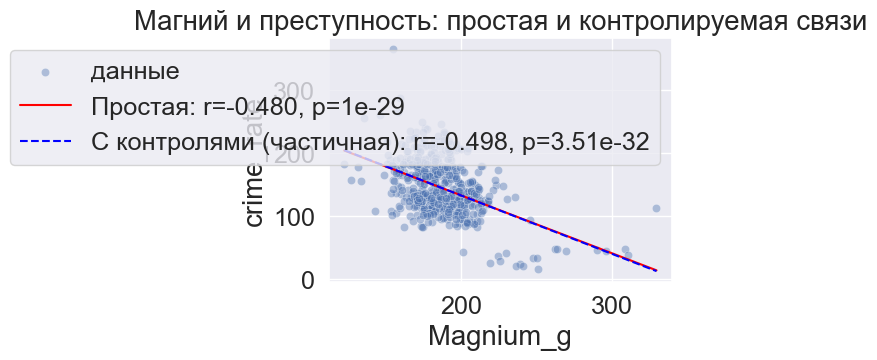

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr  # [web:381][web:404]

# данные
cols = ["Magnium_g", "crime_rate", "grp", "gini", "poverty"]
sub = panel[cols].dropna().copy()

y = sub["crime_rate"]

# 1) Простая регрессия: crime_rate ~ Magnium_g (для линии)
X_simple = sm.add_constant(sub["Magnium_g"])
ols_simple = sm.OLS(y, X_simple).fit()

# простая корреляция r (без контролей)
r_simple, p_simple = pearsonr(sub["Magnium_g"], sub["crime_rate"])  # [web:402][web:421]

# 2) Регрессия с контролями: crime_rate ~ Magnium_g + grp + gini + poverty (для линии)
X_ctrl = sm.add_constant(sub[["Magnium_g", "grp", "gini", "poverty"]])
ols_ctrl = sm.OLS(y, X_ctrl).fit()

# частичная корреляция через residuals
X_c = sm.add_constant(sub[["grp", "gini", "poverty"]])

model_mg = sm.OLS(sub["Magnium_g"], X_c).fit()
res_mg = model_mg.resid

model_cr = sm.OLS(sub["crime_rate"], X_c).fit()
res_cr = model_cr.resid

r_partial, p_partial = pearsonr(res_mg, res_cr)  # [web:417][web:422]

# сетка по Magnium_g для линий
x_grid = np.linspace(sub["Magnium_g"].min(), sub["Magnium_g"].max(), 100)
X_grid_simple = sm.add_constant(x_grid)

# для контролируемой модели фиксируем контролы на средних значениях
controls_mean = sub[["grp", "gini", "poverty"]].mean()
X_grid_ctrl = pd.DataFrame({
    "const": 1.0,
    "Magnium_g": x_grid,
    "grp": controls_mean["grp"],
    "gini": controls_mean["gini"],
    "poverty": controls_mean["poverty"],
})

y_simple_line = ols_simple.predict(X_grid_simple)
y_ctrl_line = ols_ctrl.predict(X_grid_ctrl)

# график
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=sub,
    x="Magnium_g",
    y="crime_rate",
    alpha=0.4,
    label="данные"
)

plt.plot(
    x_grid, y_simple_line,
    color="red",
    label=f"Простая: r={r_simple:.3f}, p={p_simple:.3g}"
)
plt.plot(
    x_grid, y_ctrl_line,
    color="blue", linestyle="--",
    label=f"С контролями (частичная): r={r_partial:.3f}, p={p_partial:.3g}"
)

plt.xlabel("Magnium_g")
plt.ylabel("crime_rate")
plt.title("Магний и преступность: простая и контролируемая связи")
plt.legend()
plt.tight_layout()
plt.show()




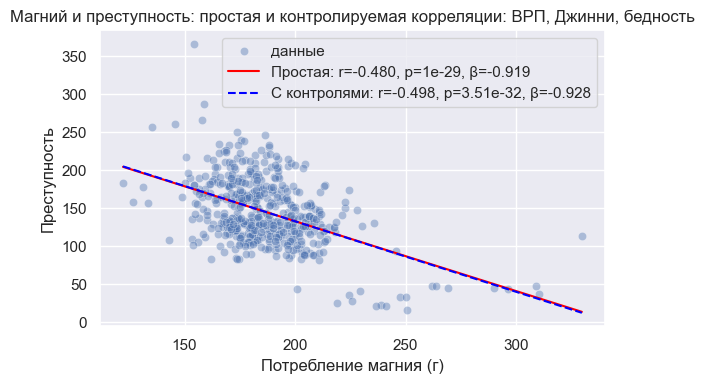

In [68]:
cols = ["Magnium_g", "crime_rate", "grp", "gini", "poverty"] 
sub = panel[cols].dropna().copy()
sns.set(font_scale=1)
# линии регрессий
X_simple = sm.add_constant(sub["Magnium_g"])
y = sub["crime_rate"]
ols_simple = sm.OLS(y, X_simple).fit()

X_ctrl = sm.add_constant(sub[["Magnium_g", "grp", "gini", "poverty"]])
ols_ctrl = sm.OLS(y, X_ctrl).fit()

# вытаскиваем беты по магнию
beta_simple = ols_simple.params["Magnium_g"]
beta_ctrl = ols_ctrl.params["Magnium_g"]

x_grid = np.linspace(sub["Magnium_g"].min(), sub["Magnium_g"].max(), 100)
X_grid_simple = sm.add_constant(x_grid)

controls_mean = sub[["grp", "gini", "poverty"]].mean()
X_grid_ctrl = pd.DataFrame({
    "const": 1.0,
    "Magnium_g": x_grid,
    "grp": controls_mean["grp"],
    "gini": controls_mean["gini"],
    "poverty": controls_mean["poverty"],
})

y_simple_line = ols_simple.predict(X_grid_simple)
y_ctrl_line = ols_ctrl.predict(X_grid_ctrl)

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=sub,
    x="Magnium_g",
    y="crime_rate",
    alpha=0.4,
    label="данные"
)

plt.plot(
    x_grid, y_simple_line,
    color="red",
    label=(
        f"Простая: r={r_simple:.3f}, p={p_simple:.3g}, "
        f"β={beta_simple:.3f}"
    )
)
plt.plot(
    x_grid, y_ctrl_line,
    color="blue", linestyle="--",
    label=(
        f"С контролями: "
        f"r={r_partial:.3f}, p={p_partial:.3g}, β={beta_ctrl:.3f}"
    )
)

plt.xlabel("Потребление магния (г)")
plt.ylabel("Преступность")
plt.title("Магний и преступность: простая и контролируемая корреляции: ВРП, Джинни, бедность")
plt.legend()
plt.tight_layout()
plt.show()
sns.set(font_scale=1)


Частичная корреляция (FE + контролы): r = -0.413, p = 1.14e-21
Бета (FE + контролы): beta = -0.826


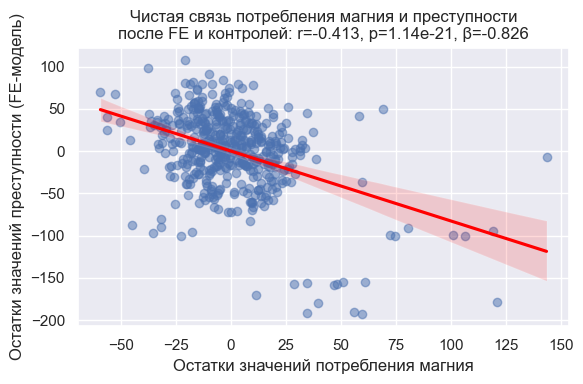

In [71]:
import statsmodels.api as sm
from scipy.stats import pearsonr

# регрессия crime_rate только на FE (region+year)
res_crime = resid_fe

# остатки Magnium_g после контролей (как у тебя)
X_ctrl = df_panel[["grp", "gini", "poverty"]]
X_ctrl = sm.add_constant(X_ctrl)
model_mag = sm.OLS(df_panel["Magnium_g"], X_ctrl).fit()
res_mag = model_mag.resid

# частичная корреляция
r_fe, p_fe = pearsonr(res_mag, res_crime)
print(f"Частичная корреляция (FE + контролы): r = {r_fe:.3f}, p = {p_fe:.3g}")

# ОЦЕНИВАЕМ БЕТУ ДЛЯ ОСТАТКОВ
X_beta = sm.add_constant(res_mag)
beta_model = sm.OLS(res_crime, X_beta).fit()
# вместо того, чтобы хранить res_mag как обычный ndarray/Series без имени:
res_mag = model_mag.resid
res_mag = pd.Series(res_mag, name="res_mag")  # добавляем имя

X_beta = sm.add_constant(res_mag)
beta_model = sm.OLS(res_crime, X_beta).fit()

# Доставать по имени, а не по индексу 1
beta_fe = beta_model.params["res_mag"]


print(f"Бета (FE + контролы): beta = {beta_fe:.3f}")

plt.figure(figsize=(6, 4))
sns.regplot(
    x=res_mag,
    y=res_crime,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
plt.xlabel("Остатки значений потребления магния")
plt.ylabel("Остатки значений преступности (FE-модель)")
plt.title(
    "Чистая связь потребления магния и преступности\n"
    f"после FE и контролей: r={r_fe:.3f}, p={p_fe:.3g}, β={beta_fe:.3f}"
)
plt.tight_layout()
plt.show()


                          PanelOLS Estimation Summary                           
Dep. Variable:             crime_rate   R-squared:                        0.0863
Estimator:                   PanelOLS   R-squared (Between):             -0.0747
No. Observations:                 492   R-squared (Within):              -0.1162
Date:                Mon, Dec 15 2025   R-squared (Overall):             -0.0768
Time:                        20:36:46   Log-likelihood                   -1800.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      9.4696
Entities:                          82   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                   F(4,401)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             9.4696
                            

C:\Users\User\AppData\Local\Temp\ipykernel_23820\2440200371.py:83: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\User\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


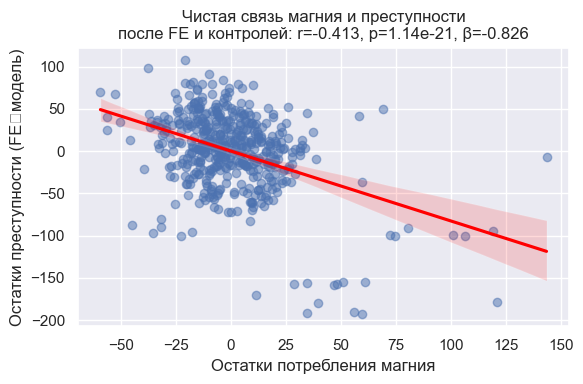

In [73]:
import pandas as pd
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# оставляем нужные переменные и убираем пропуски
cols = ["region", "year", "crime_rate", "Magnium_g", "grp", "gini", "poverty"]
df = panel[cols].dropna().copy()

# панельный индекс region–year
df_panel = df.set_index(["region", "year"]).sort_index()

y = df_panel["crime_rate"]
X = df_panel[["Magnium_g", "grp", "gini", "poverty"]]
X = sm.add_constant(X)
# 1. FE по регионам и годам, обычные SE
mod_fe = PanelOLS(
    y, X,
    entity_effects=True,   # фиксированные эффекты регионов
    time_effects=True      # фиксированные эффекты лет
)

fe_res = mod_fe.fit(cov_type="unadjusted")
print(fe_res.summary)      # базовые оценки

# 2. Кластер по регионам
fe_res_cl_ent = mod_fe.fit(
    cov_type="clustered",
    cluster_entity=True,
    cluster_time=False
)
print("\n=== FE, кластер по регионам ===")
print(fe_res_cl_ent.summary)

# 3. Кластер по годам
fe_res_cl_time = mod_fe.fit(
    cov_type="clustered",
    cluster_entity=False,
    cluster_time=True
)
print("\n=== FE, кластер по годам ===")
print(fe_res_cl_time.summary)

# 4. Кластер по регионам и годам (двойной кластер)
fe_res_cl_both = mod_fe.fit(
    cov_type="clustered",
    cluster_entity=True,
    cluster_time=True
)
print("\n=== FE, кластер по регионам и годам ===")
print(fe_res_cl_both.summary)
import statsmodels.api as sm
from scipy.stats import pearsonr
df_panel["crime_pred_fe"] = fe_res_cl_ent.predict()


# остатки преступности после FE‑модели
res_crime = df_panel["crime_rate"] - df_panel["crime_pred_fe"]

# остатки магния после контролей (grp, gini, poverty)
X_ctrl = sm.add_constant(df_panel[["grp", "gini", "poverty"]])
model_mag = sm.OLS(df_panel["Magnium_g"], X_ctrl).fit()
res_mag = pd.Series(model_mag.resid, name="res_mag")

# r, p, beta
r_fe, p_fe = pearsonr(res_mag, res_crime)
X_beta = sm.add_constant(res_mag)
beta_model = sm.OLS(res_crime, X_beta).fit()
beta_fe = beta_model.params["res_mag"]

plt.figure(figsize=(6, 4))
sns.regplot(
    x=res_mag,
    y=res_crime,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
plt.xlabel("Остатки потребления магния")
plt.ylabel("Остатки преступности (FE‑модель)")
plt.title(
    "Чистая связь магния и преступности\n"
    f"после FE и контролей: r={r_fe:.3f}, p={p_fe:.3g}, β={beta_fe:.3f}"
)
plt.tight_layout()
plt.show()


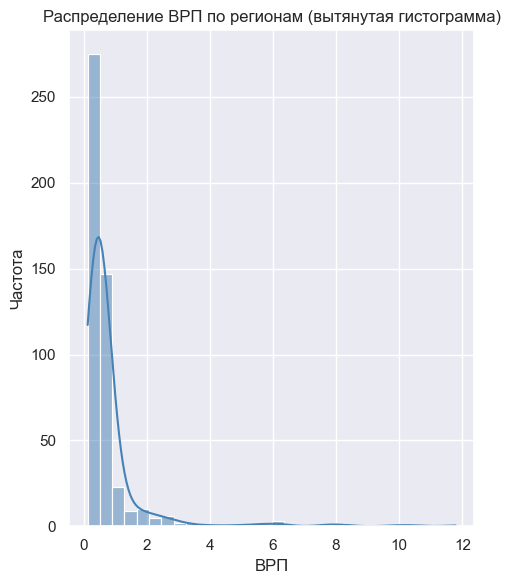

In [86]:
plt.figure(figsize=(5, 6))  # шире и ниже
sns.histplot(
    data=panel,
    x="grp",
    bins=30,        # больше бинов → более детальная форма
    kde=True,
    color="steelblue"
)
plt.xlabel("ВРП")
plt.ylabel("Частота")
plt.title("Распределение ВРП по регионам (вытянутая гистограмма)")
plt.tight_layout()
plt.show()


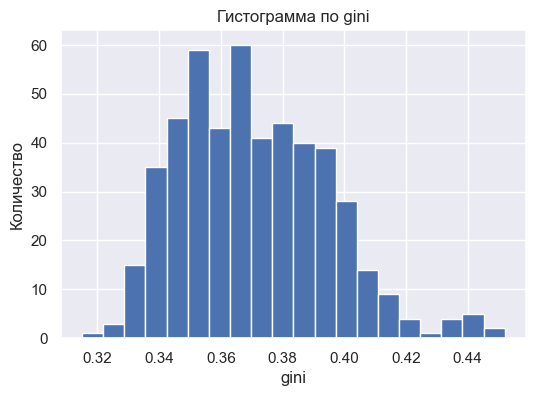

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
panel['gini'].hist(bins=20)
plt.xlabel('gini')
plt.ylabel('Количество')
plt.title('Гистограмма по gini')
plt.show()


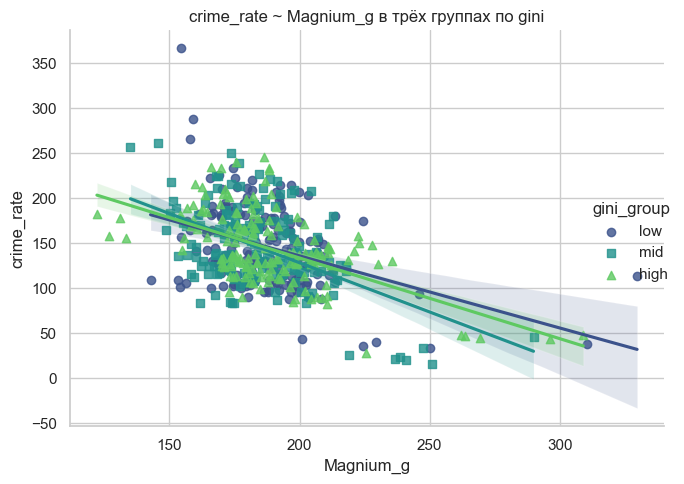

In [98]:
import pandas as pd

panel['gini_group'] = pd.qcut(panel['gini'], q=3,
                              labels=['low', 'mid', 'high'])
import statsmodels.formula.api as smf

models = {}
for grp in ['low', 'mid', 'high']:
    df_sub = panel[panel['gini_group'] == grp].copy()
    df_sub = df_sub[['Magnium_g', 'crime_rate']].dropna()
    models[grp] = smf.ols('crime_rate ~ Magnium_g', data=df_sub).fit()
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

sns.lmplot(
    data=panel,
    x='Magnium_g', y='crime_rate',
    hue='gini_group',
    markers=['o', 's', '^'],
    palette='viridis',
    height=5, aspect=1.2
)

plt.xlabel('Magnium_g')
plt.ylabel('crime_rate')
plt.title('crime_rate ~ Magnium_g в трёх группах по gini')
plt.tight_layout()
plt.show()


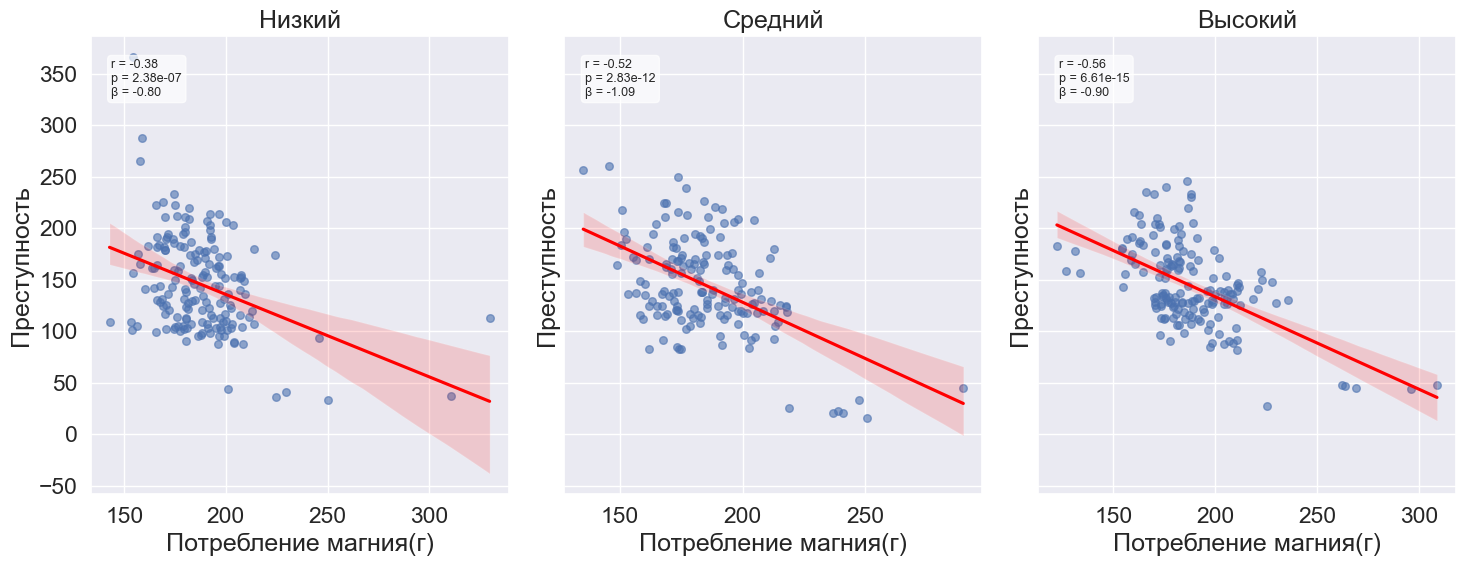

In [109]:
sns.set(font_scale=1.5)
titles = {'low': 'Низкий', 'mid': 'Средний', 'high': 'Высокий'}

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
groups = ['low', 'mid', 'high']

for ax, grp in zip(axes, groups):
    df_sub = panel[panel['gini_group'] == grp][['Magnium_g', 'crime_rate']].dropna()

    res = stats.linregress(df_sub['Magnium_g'], df_sub['crime_rate'])
    r = res.rvalue
    p = res.pvalue
    beta = res.slope

    sns.regplot(
        data=df_sub,
        x='Magnium_g', y='crime_rate',
        ax=ax,
        scatter_kws={'alpha': 0.6, 's': 30},
        line_kws={'color': 'red'}
    )

    ax.text(
        0.05, 0.95,
        f'r = {r:.2f}\np = {p:.3g}\nβ = {beta:.2f}',
        transform=ax.transAxes,
        va='top', ha='left',
        fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

    ax.set_title(titles[grp])   # <-- русские заголовки

    ax.set_xlabel('Потребление магния(г)')
    ax.set_ylabel('Преступность')

plt.tight_layout()
plt.show()


In [ ]:

import pandas as pd
from linearmodels.panel import PanelOLS, RandomEffects
panel_haus = panel.set_index(['region', 'year']).sort_index()
# фиксированные эффекты (по регионам + годам)
fe_model = PanelOLS.from_formula(
    'crime_rate ~ Magnium_g + grp + gini + poverty + EntityEffects + TimeEffects',
    data=panel_haus
).fit(cov_type='clustered', cluster_entity=True)

# случайные эффекты
re_model = RandomEffects.from_formula(
    'crime_rate ~ Magnium_g + grp + gini + poverty',
    data=panel_haus
).fit()
from linearmodels.panel import compare

res = compare({'FE': fe_model, 'RE': re_model})
print(res)


                    Model Comparison                    
                                    FE                RE
--------------------------------------------------------
Dep. Variable               crime_rate        crime_rate
Estimator                     PanelOLS     RandomEffects
No. Observations                   492               492
Cov. Est.                    Clustered        Unadjusted
R-squared                       0.0863            0.6919
R-Squared (Within)             -0.1162           -0.0039
R-Squared (Between)             0.8070            0.9255
R-Squared (Overall)             0.8029            0.9214
F-statistic                     9.4696            273.99
P-value (F-stat)                0.0000            0.0000
=====================     ============   ===============
Magnium_g                      -0.1016           -0.1005
                             (-1.9060)         (-2.0981)
grp                            -2.0489            0.6084
                             (-

In [112]:
import pandas as pd
from linearmodels.panel import PanelOLS, RandomEffects
import numpy as np

# 1. Задать панельный индекс (подставь свои имена id и времени)
panel_haus = panel.set_index(['region', 'year']).sort_index()

# 2. FE-модель
fe_model = PanelOLS.from_formula(
    'crime_rate ~ Magnium_g + grp + gini + poverty + EntityEffects + TimeEffects',
    data=panel_haus
).fit(cov_type='clustered', cluster_entity=True)

# 3. RE-модель
re_model = RandomEffects.from_formula(
    'crime_rate ~ Magnium_g + grp + gini + poverty',
    data=panel_haus
).fit()

print(fe_model)
print(re_model)

# 4. Тест Хаусмана (ручная реализация)

# берём только общие коэффициенты (без константы, если она есть)
common_coef = fe_model.params.index.intersection(re_model.params.index)
b_fe = fe_model.params[common_coef]
b_re = re_model.params[common_coef]

V_fe = fe_model.cov.iloc[
    [fe_model.params.index.get_loc(c) for c in common_coef],
    [fe_model.params.index.get_loc(c) for c in common_coef]
]
V_re = re_model.cov.iloc[
    [re_model.params.index.get_loc(c) for c in common_coef],
    [re_model.params.index.get_loc(c) for c in common_coef]
]

diff = b_fe - b_re
V_diff = V_fe - V_re

# инверсия ковариационной матрицы
from numpy.linalg import inv

chi2_stat = float(diff.T @ inv(V_diff) @ diff)
df = len(diff)

from scipy import stats
p_value = 1 - stats.chi2.cdf(chi2_stat, df)

print('\nHausman test')
print('Chi2 =', chi2_stat)
print('df   =', df)
print('p-value =', p_value)


                          PanelOLS Estimation Summary                           
Dep. Variable:             crime_rate   R-squared:                        0.0863
Estimator:                   PanelOLS   R-squared (Between):              0.8070
No. Observations:                 492   R-squared (Within):              -0.1162
Date:                 Пн, дек 15 2025   R-squared (Overall):              0.8029
Time:                        21:23:52   Log-likelihood                   -1800.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      9.4696
Entities:                          82   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                   F(4,401)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             2.1702
                            